In [227]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchtext import data, datasets
import spacy
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

dev = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
from utils import Multi30KEn2DeDatasetTokenizer
dataset = Multi30KEn2DeDatasetTokenizer(dev=dev)

In [222]:
dl = DataLoader(
    dataset.train, shuffle=True, batch_size=128, collate_fn=dataset.collate_fn)
example =  next(iter(dl))
{a: example[a].shape for a in example}

1


{'src': torch.Size([128, 28]),
 'trg': torch.Size([128, 26]),
 'src_mask': torch.Size([128, 1, 1, 28]),
 'trg_mask': torch.Size([128, 1, 26, 26]),
 'trg_y': torch.Size([128, 26])}

In [107]:
from transformers.model import EncoderDecoder, Trainer
import os

def get_trainer():
    model = EncoderDecoder(
        len(dataset.src_vocab),
        len(dataset.trg_vocab)).to(dev)

    trainer = Trainer(model)
    try:
        chks = os.listdir('./chkpnts')
        ns = [int(chk.split('checkpnt_step-')[1].split('k.pt')[0])
             for chk in chks]
        if len(ns) == 0:
            raise Exception('No checkpoints in ./chkpnts')
        n = sorted(ns)[-1]
        print(f'checkpnt_epoch-{n}k.pt')
        trainer.load(f'chkpnts/checkpnt_step-{n}k.pt')

    except Exception as e:
        print('error: ', e)
    return trainer, model

trainer, model = get_trainer()

checkpnt_epoch-850k.pt


In [5]:
trainer.train_loop(1_000_000, dl)

 10%|#         | 100000/1000000 [00:00<?, ?it/s]


KeyboardInterrupt



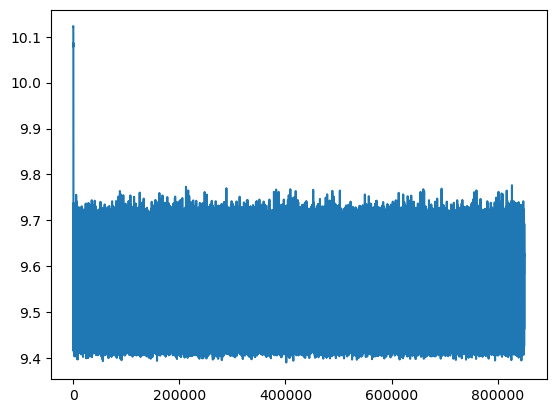

In [228]:
plt.plot(trainer.losses)

In [229]:
test_dl = DataLoader(
    dataset.train, shuffle=True, batch_size=1, collate_fn=dataset.collate_fn)
example =  next(iter(test_dl))
{a: example[a].shape for a in example}

src = example['src']
tgt = example['trg']
src_mask = example['src_mask']
tgt_mask = example['trg_mask']
trg_y = example['trg_y']

model.eval()

tgt = model.tgt_embed(tgt)
ys = torch.zeros(1, 1).fill_(dataset.start_symbol).type_as(src.data)
memory = model.encode(src, src_mask)

for _ in range(10):
    out = model.decode(
        ys, dataset.subsequent_mask(ys.size(1)).type_as(src.data).to(dev), memory, src_mask
        )

    prob = model.generator(out[:, -1])

    _, next_word = torch.max(prob, dim=1)
    ys = torch.cat(
                [ys, next_word.unsqueeze(0)],
        dim=1
    )

dataset.itos(src[0], field='src'), dataset.itos(ys[0])

1


('<s> These students in class are sitting down doing work. </s>',
 '<s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>')